In [1]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from weighted_model.fair_teacher_student_classifier import FairTeacherStudentClassifier
from weighted_model.teacher_student_classifier import TeacherStudentClassifier
from curriculum_models.curriculum_student_teacher import CurriculumStudentTeacher
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility

In [2]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
#df.head()


48842


In [3]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [4]:

def split_into_parts(X, y_prob, n_splits = 5):
    """Splits X and y into 5 equal parts and returns them as a list of (X_part, y_part)."""
    split_size = len(X) // n_splits
    
    # Convert probabilities to predictions
    y_pred = np.argmax(y_prob, axis=1)

    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X)
        split_data.append((X[start_idx:end_idx], y_pred[start_idx:end_idx]))

    return split_data


In [5]:
import numpy as np
import pandas as pd

## TODO - Partially Fit then test - then fit again with weights on misslassified samples

def split_into_difficulty_parts(X, y_prob, n_splits=5, ascending=False):
    """Splits X and y into 5 parts based on the highest prediction probability, 
    with the most difficult samples (lowest probability) getting split last.
    """
    split_size = len(X) // n_splits
    
    # Get the maximum probability and corresponding predicted class
    max_prob = np.max(y_prob, axis=1)  # Get highest probability for each sample
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted class labels

    # Combine X (DataFrame), y_pred, and max_prob into a single DataFrame for sorting
    X_sorted = X.copy()  # Work with a copy to avoid modifying original
    X_sorted['y_pred'] = y_pred
    X_sorted['max_prob'] = max_prob
    
    # By default: Sort by the highest probability (descending order) - more confident predictions come first
    X_sorted = X_sorted.sort_values(by='max_prob', ascending=ascending)

    #print(X_sorted.head())    
    # Split the sorted data into n_splits parts
    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X_sorted)
        split_X = X_sorted.iloc[start_idx:end_idx].drop(columns=['y_pred', 'max_prob'])  # Drop auxiliary columns
        #print(split_X.head())
        split_y_pred = X_sorted.iloc[start_idx:end_idx]['y_pred']
        split_data.append((split_X, split_y_pred))

    return split_data


In [6]:
def split_into_difficulty_parts_asc(X, y_prob, n_splits=5):
    return split_into_difficulty_parts(X, y_prob, n_splits, ascending=True)


In [7]:
# Define random states
random_states = [1, 40, 42, 123]

# Curriculum Learning Models with three random states
curriculum_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_parts, split_data=False, random_state=rs) for rs in random_states}

difficulty_based_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_difficulty_parts, split_data=False, random_state=rs) for rs in random_states}

difficulty_based_no_shuffle_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_difficulty_parts, split_data=False, random_state=rs, shuffle=False) for rs in random_states}


# tried max_iter=1000 and alpha=0.00001
# Setting Average=True seems to fix the problem with random state
sgd_models = {rs: SGDClassifier(random_state=rs) for rs in random_states}

# Train models
for rs in random_states:
    curriculum_models[rs].fit(X_train, y_train)
    difficulty_based_models[rs].fit(X_train, y_train)
    difficulty_based_no_shuffle_models[rs].fit(X_train, y_train)
    sgd_models[rs].fit(X_train, y_train)

# Make predictions
curriculum_model_predictions = {rs: curriculum_models[rs].predict(X_test) for rs in random_states}
difficulty_based_model_predictions = {rs: difficulty_based_models[rs].predict(X_test) for rs in random_states}
difficulty_based_no_shuffle_model_predictions = {rs: difficulty_based_no_shuffle_models[rs].predict(X_test) for rs in random_states}
sgd_predictions = {rs: sgd_models[rs].predict(X_test) for rs in random_states}

{'Curriculum Model (1)': 0.7954754836728427, 'Curriculum Model (40)': 0.23932848807452145, 'Curriculum Model (42)': 0.7834988228068379, 'Curriculum Model (123)': 0.7958849421639881, 'Difficulty Based Model (1)': 0.23932848807452145, 'Difficulty Based Model (40)': 0.23932848807452145, 'Difficulty Based Model (42)': 0.7794042378953834, 'Difficulty Based Model (123)': 0.23932848807452145, 'Difficulty Based No Shuffle Model (1)': 0.7842153751663425, 'Difficulty Based No Shuffle Model (40)': 0.7946565666905517, 'Difficulty Based No Shuffle Model (42)': 0.7939400143310472, 'Difficulty Based No Shuffle Model (123)': 0.7833964581840516, 'SGD Model (1)': 0.23932848807452145, 'SGD Model (40)': 0.23932848807452145, 'SGD Model (42)': 0.7941447435766199, 'SGD Model (123)': 0.7943494728221927}


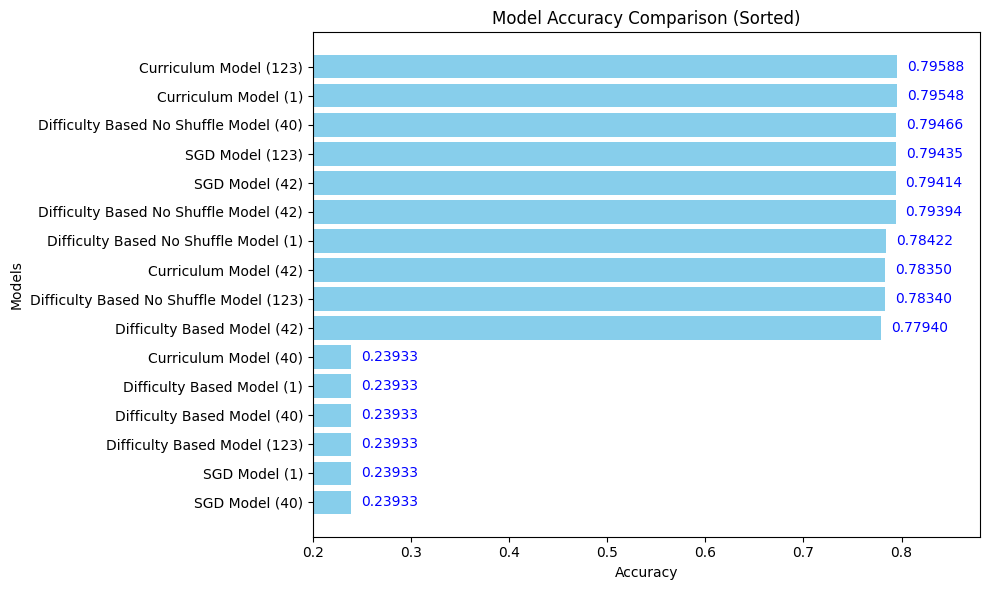

In [8]:
# Now calculate accuracies for each model
accuracies = {}

# Curriculum Model accuracy
for rs in random_states:
    accuracies[f"Curriculum Model ({rs})"] = accuracy_score(y_test, curriculum_model_predictions[rs])

# Difficulty Based Model accuracy
for rs in random_states:
    accuracies[f"Difficulty Based Model ({rs})"] = accuracy_score(y_test, difficulty_based_model_predictions[rs])

# Difficulty Based No Shuffle Model accuracy
for rs in random_states:
    accuracies[f"Difficulty Based No Shuffle Model ({rs})"] = accuracy_score(y_test, difficulty_based_no_shuffle_model_predictions[rs])

# SGD Model accuracy
for rs in random_states:
    accuracies[f"SGD Model ({rs})"] = accuracy_score(y_test, sgd_predictions[rs])
# Print the accuracy results
print(accuracies)

# Sort models by accuracy in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.xlim(0.2, 0.88)  # Adjust the x-axis limits to fit the data range

# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()

In [9]:
# Define random states
random_states = [1, 40, 42, 123]

# Curriculum Learning Models with three random states
curriculum_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_parts, split_data=False, random_state=rs) for rs in random_states}

difficulty_based_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_difficulty_parts, split_data=False, random_state=rs) for rs in random_states}

difficulty_based_no_shuffle_models = {rs: CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type=SGDClassifier, transform_func=split_into_difficulty_parts, split_data=False, random_state=rs, shuffle=False) for rs in random_states}

sgd_models = {rs: SGDClassifier(random_state=rs, average=True) for rs in random_states}

# Train models
for rs in random_states:
    curriculum_models[rs].fit(X_train, y_train)
    difficulty_based_models[rs].fit(X_train, y_train)
    difficulty_based_no_shuffle_models[rs].fit(X_train, y_train)
    sgd_models[rs].fit(X_train, y_train)

# Make predictions
curriculum_model_predictions = {rs: curriculum_models[rs].predict(X_test) for rs in random_states}
difficulty_based_model_predictions = {rs: difficulty_based_models[rs].predict(X_test) for rs in random_states}
difficulty_based_no_shuffle_model_predictions = {rs: difficulty_based_no_shuffle_models[rs].predict(X_test) for rs in random_states}
sgd_predictions = {rs: sgd_models[rs].predict(X_test) for rs in random_states}

{'Curriculum Model (1)': 0.7948612959361244, 'Curriculum Model (40)': 0.23932848807452145, 'Curriculum Model (42)': 0.7833964581840516, 'Curriculum Model (123)': 0.7954754836728427, 'Difficulty Based Model (1)': 0.23932848807452145, 'Difficulty Based Model (40)': 0.7947589313133381, 'Difficulty Based Model (42)': 0.7925069096120381, 'Difficulty Based Model (123)': 0.23932848807452145, 'Difficulty Based No Shuffle Model (1)': 0.23932848807452145, 'Difficulty Based No Shuffle Model (40)': 0.23932848807452145, 'Difficulty Based No Shuffle Model (42)': 0.7838059166751971, 'Difficulty Based No Shuffle Model (123)': 0.7753096529839287, 'SGD Model (1)': 0.7959873067867745, 'SGD Model (40)': 0.7960896714095609, 'SGD Model (42)': 0.7962944006551336, 'SGD Model (123)': 0.7958849421639881}


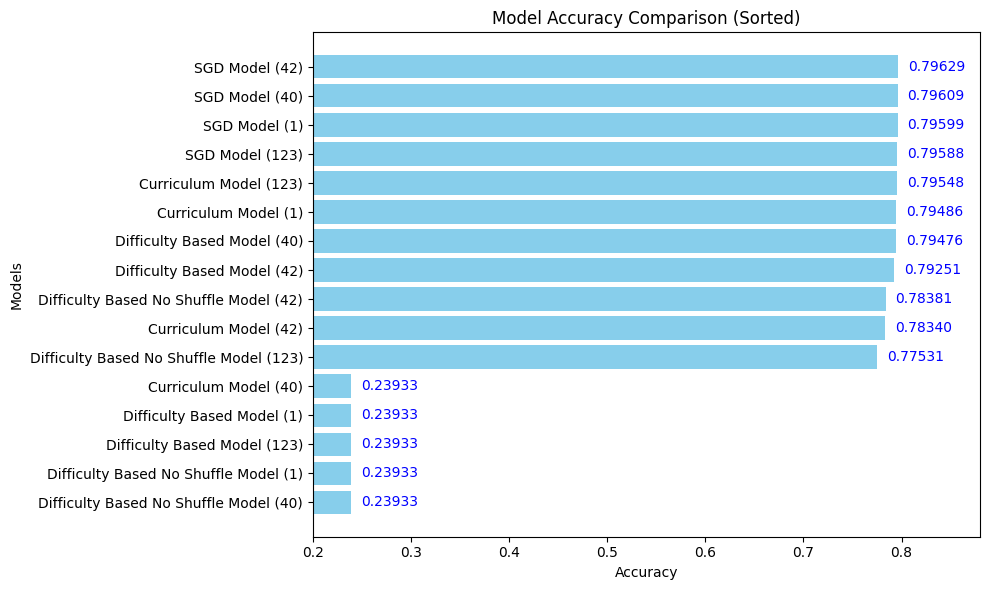

In [10]:
# Now calculate accuracies for each model
accuracies = {}

# Curriculum Model accuracy
for rs in random_states:
    accuracies[f"Curriculum Model ({rs})"] = accuracy_score(y_test, curriculum_model_predictions[rs])

# Difficulty Based Model accuracy
for rs in random_states:
    accuracies[f"Difficulty Based Model ({rs})"] = accuracy_score(y_test, difficulty_based_model_predictions[rs])

# Difficulty Based No Shuffle Model accuracy
for rs in random_states:
    accuracies[f"Difficulty Based No Shuffle Model ({rs})"] = accuracy_score(y_test, difficulty_based_no_shuffle_model_predictions[rs])

# SGD Model accuracy
for rs in random_states:
    accuracies[f"SGD Model ({rs})"] = accuracy_score(y_test, sgd_predictions[rs])
# Print the accuracy results
print(accuracies)

# Sort models by accuracy in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.xlim(0.2, 0.88)  # Adjust the x-axis limits to fit the data range

# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()

# Findings  

After analyzing multiple solutions, the goal was to minimize the impact of the random state on the model. I found that setting `max_iter=1000` and `alpha=0.00001` had no significant effect in this regard. However, enabling `average=True` proved to be highly effective in stabilizing the SGD model. Not shuffling the data also appears to not have an effect.

### Definition of `average`:  
**`average` (bool or int, default=False)**  
- When set to `True`, the model computes the averaged SGD weights across all updates and stores the result in the `coef_` attribute.  
- If set to an integer greater than 1, averaging begins once the total number of samples seen reaches the specified value.  
- For example, `average=10` will start averaging after 10 samples.  
- Integer values must be in the range `[1, n_samples]`.  